In [0]:
!python --version

Python 3.7.7


In [0]:
!nvidia-smi

Fri Jun  5 08:03:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P2000        Off  | 00000000:21:00.0  On |                  N/A |
| 67%   73C    P0    27W /  75W |    473MiB /  5050MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Importing Standard Python Libraries
ls = ['math','os','sys','datetime','shutil']
for i in ls:
    exec('import {0}'.format(i))
    # exec('print("imported {0}")'.format(i))

In [0]:
# Using GDrive storage as file-system for experimentation
from google.colab import drive
try:
    drive.mount('/content/gdrive')
    os.chdir('gdrive/My Drive/COVID-CT')
except:
    pass

# Removing Permission if you want to unmount
# https://myaccount.google.com/permissions

os.getcwd()

In [0]:
# os.listdir()

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Importing Standard Data Science & Plotting libraries
import numpy as np, pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [0]:
# Importing Deep Learning Libraries
ls = ['tensorflow','h5py','sklearn']

for i in ls:
    exec('import {0}'.format(i))
    exec('print("Version of {0}",{0}.__version__)'.format(i))

Version of tensorflow 2.2.0
Version of h5py 2.10.0
Version of sklearn 0.22.1


In [0]:
IMG_SHAPE = (224,224,3)
brightness_range = (0.0, 1.0)

In [0]:
%%time
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16 as trf_model, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19 as trf_model, preprocess_input

# from tensorflow.keras.applications.resnet_v2 import ResNet50V2 as trf_model, preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet152V2 as trf_model, preprocess_input

# from tensorflow.keras.applications import InceptionResNetV2 as trf_model
# from tensorflow.keras.applications.resnet_v2 import preprocess_input


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC


def preprocessing_function(img_tensor):
    img_tensor = img_tensor.astype('float32')
    img_tensor = np.clip(255*img_tensor,0,255)
    return preprocess_input(img_tensor)

class CNN:
    "Class for creating VGG-19 based transfer learning model"

    def __init__(self, input_shape, model_choice=0):
        self.trf_model = trf_model(include_top=False, weights='imagenet', input_shape=input_shape)
        # Freexing all layers of VGG-19 to be untrainable
        self.trf_model.trainable = False
        for layer in self.trf_model.layers:
            layer.trainable = False
 
        if model_choice==0:
            "Fully connected head model on top of pre-trained VGG-19 with Dropout"
            IP = self.trf_model.output
            X = Flatten()(IP)
            X = Dense(2048)(X)
            X = BatchNormalization()(X)
            X = Activation('relu')(X)
            X = Dropout(0.25)(X)
#             X = Dense(1024)(X)
#             X = BatchNormalization()(X)
#             X = Activation('tanh')(X)
#             X = Dropout(0.25)(X)
#             X = Dense(512)(X)
#             X = BatchNormalization()(X)
#             X = Activation('relu')(X)
#             X = Dropout(0.25)(X)
            X = Dense(256)(X)
            X = BatchNormalization()(X)
            X = Activation('relu')(X)
            X = Dropout(0.25)(X)
            X = Dense(1)(X)
            OP = Activation('sigmoid')(X)
            self.model = Model(inputs=self.trf_model.input, outputs=OP)

    def train(self, train_path, valid_path, batch_size=64, epochs=300, opt='Adam', lr=0.01, verbose=1, unfreeze=0):
        self.trf_model.trainable = False
        # Opening the last few layers of VGG-19 base for fine tuning
        for ix in range(1, unfreeze+1):
            self.trf_model.layers[-1*ix].trainable = True

        # Selcting optimizer and compiling model
        opt = eval('tensorflow.keras.optimizers.{}(learning_rate={})'.format(opt, lr))
        self.model.compile(loss='binary_crossentropy',
                optimizer=opt, metrics=[ 
                    BinaryAccuracy(name='accuracy'),
                    Precision(name='precision'),
                    Recall(name='recall'),
                    AUC(name='roc-auc',num_thresholds=2*10**2)
                                        ])

        self.datagen_args = dict(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False,
            zca_epsilon=1e-06,
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range = None, #brightness_range,
            shear_range=0.0,
            zoom_range=0.25,
            fill_mode="nearest",
            cval=0.0,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=1.0/255,
            preprocessing_function = preprocess_input,
            data_format=None,
            validation_split=0.0,
            dtype=None,
        )

        train_datagen = ImageDataGenerator(**self.datagen_args)
        valid_datagen = ImageDataGenerator(**self.datagen_args)

        train_generator = train_datagen.flow_from_directory( train_path, target_size=IMG_SHAPE[:2], classes=['Healthy','Covid'],
                                                            batch_size=batch_size, class_mode='binary' )
        
        valid_generator = valid_datagen.flow_from_directory( valid_path, target_size=IMG_SHAPE[:2], classes=['Healthy','Covid'],
                                                            batch_size=batch_size, class_mode='binary' )

        # Fit the model on the batches generated by datagen.flow().
        history = self.model.fit( train_generator,epochs=epochs,
                                 steps_per_epoch = 8*200//batch_size,
                                 validation_data=valid_generator,
                                 validation_steps= 8*60//batch_size,
                                 callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True),
                                            ReduceLROnPlateau(monitor='loss', factor=1/3, patience=5, min_delta=1e-4, min_lr=1e-6, verbose=1)],
                                 verbose=verbose,
                                 workers=4)
        self.history = history.history

    def evaluate(self,test_path):
        size = sum(len(os.listdir(os.path.join(test_path,x))) for x in os.listdir(test_path))
        datagen = ImageDataGenerator( rescale=1. / 255, preprocessing_function = preprocess_input )
        generator = datagen.flow_from_directory( test_path, target_size=IMG_SHAPE[:2], classes=['Healthy','Covid'],
                                                batch_size=1*1+0*size,
                                                shuffle=False, class_mode='binary' )        
        scores = self.model.evaluate( generator, verbose=1, return_dict=True,
                                     batch_size=1*1+0*size, steps=0*1+1*size )
        return scores

    def predict(self,test_path):
        size = sum(len(os.listdir(os.path.join(test_path,x))) for x in os.listdir(test_path))
        print(size)
        datagen = ImageDataGenerator( rescale=1. / 255, preprocessing_function = preprocess_input )
        generator = datagen.flow_from_directory( test_path, target_size=IMG_SHAPE[:2], classes=['Healthy','Covid'],
                                                batch_size=1*1+0*size,
                                                shuffle=False, class_mode='binary' )        
        y_pred = self.model.predict( generator, verbose=1,
                                     batch_size=1*1+0*size, steps=0*1+1*size )
        return y_pred

    def plot(self, metric='loss'):
        for key in self.history:
            if metric in key:
                plt.plot(self.history[key],label=key)
        plt.legend()
        plt.grid(True, which='both')
        plt.xlabel('Number of Epochs')
        plt.ylabel('{} value'.format(metric))
        plt.title('Training progress of {}'.format(metric))
        plt.show()

CPU times: user 76 µs, sys: 0 ns, total: 76 µs
Wall time: 80.8 µs


In [0]:
os.getcwd()

'/mnt/sdb2/achintc/COVID-CT'

In [0]:
model = CNN(IMG_SHAPE)

In [0]:
%%time
model.train( os.path.join('Data','Train'), os.path.join('Data','Valid'),
            batch_size=64, epochs=100, opt='Adam', lr=0.0001, verbose=1)

Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Epoch 1/100
25/25 [==============================] - 41s 2s/step - loss: 0.5623 - accuracy: 0.7289 - precision: 0.7229 - recall: 0.6464 - roc-auc: 0.8130 - val_loss: 0.6800 - val_accuracy: 0.6148 - val_precision: 0.7449 - val_recall: 0.3493 - val_roc-auc: 0.7057 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 20s 812ms/step - loss: 0.3971 - accuracy: 0.8216 - precision: 0.8036 - recall: 0.7976 - roc-auc: 0.9005 - val_loss: 0.6251 - val_accuracy: 0.6675 - val_precision: 0.6816 - val_recall: 0.6462 - val_roc-auc: 0.7277 - lr: 1.0000e-04
Epoch 3/100
25/25 [==============================] - 20s 810ms/step - loss: 0.2860 - accuracy: 0.8824 - precision: 0.8767 - recall: 0.8588 - roc-auc: 0.9512 - val_loss: 0.6039 - val_accuracy: 0.7057 - val_precision: 0.7812 - val_recall: 0.5869 - val_roc-auc: 0.7714 - lr: 1.0000e-04
Epoch 4/100
25/25 [==============================] - 20s 803ms/step - lo

In [0]:
model.evaluate(os.path.join('Data','Valid'))

Found 118 images belonging to 2 classes.
118/118 [==============================] - 3s 26ms/step - loss: 0.5921 - accuracy: 0.7542 - precision: 0.7719 - recall: 0.7333 - roc-auc: 0.7932


{'loss': 0.5920591354370117,
 'accuracy': 0.7542372941970825,
 'precision': 0.7719298005104065,
 'recall': 0.7333333492279053,
 'roc-auc': 0.7932471036911011}

In [0]:
model.evaluate(os.path.join('Data','Test'))

Found 203 images belonging to 2 classes.
203/203 [==============================] - 5s 26ms/step - loss: 0.5283 - accuracy: 0.7586 - precision: 0.7475 - recall: 0.7551 - roc-auc: 0.8246


{'loss': 0.5283334851264954,
 'accuracy': 0.7586206793785095,
 'precision': 0.747474730014801,
 'recall': 0.7551020383834839,
 'roc-auc': 0.8246355652809143}

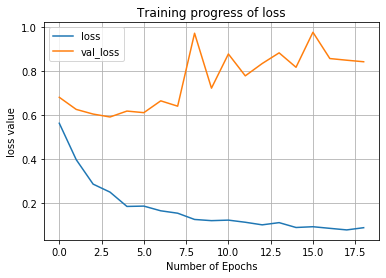

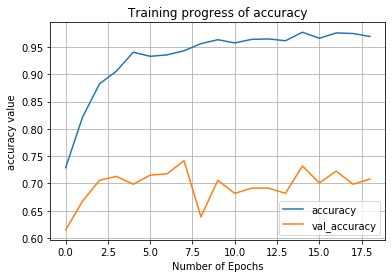

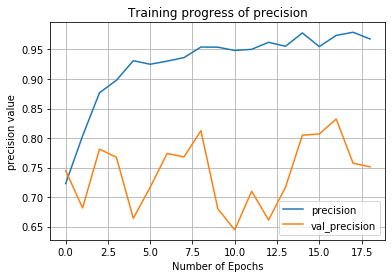

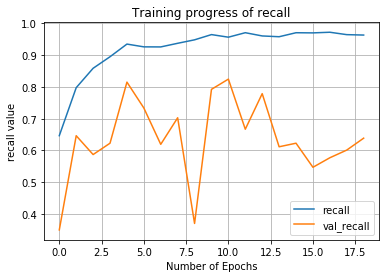

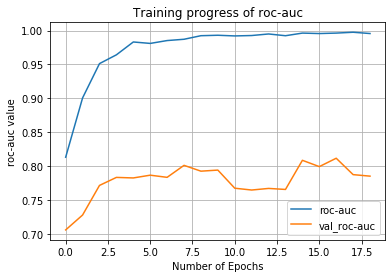

In [0]:
for name in ('loss','accuracy','precision','recall','roc-auc'):
    model.plot(name)

In [0]:
%%time
model.train( os.path.join('Data','Train'), os.path.join('Data','Valid'),
            batch_size=64, epochs=100, opt='Adam', lr=0.0001, verbose=1, unfreeze=5)

Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Epoch 1/100
25/25 [==============================] - 27s 1s/step - loss: 0.3235 - accuracy: 0.8628 - precision: 0.8492 - recall: 0.8443 - roc-auc: 0.9371 - val_loss: 0.6312 - val_accuracy: 0.7297 - val_precision: 0.7692 - val_recall: 0.6635 - val_roc-auc: 0.8179 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 22s 865ms/step - loss: 0.2233 - accuracy: 0.9158 - precision: 0.9057 - recall: 0.9096 - roc-auc: 0.9691 - val_loss: 1.4069 - val_accuracy: 0.6459 - val_precision: 0.5964 - val_recall: 0.9340 - val_roc-auc: 0.7581 - lr: 1.0000e-04
Epoch 3/100
25/25 [==============================] - 22s 870ms/step - loss: 0.1344 - accuracy: 0.9510 - precision: 0.9433 - recall: 0.9474 - roc-auc: 0.9894 - val_loss: 0.7012 - val_accuracy: 0.7895 - val_precision: 0.7753 - val_recall: 0.8263 - val_roc-auc: 0.8424 - lr: 1.0000e-04
Epoch 4/100
25/25 [==============================] - 22s 867ms/step - lo

In [0]:
model.evaluate(os.path.join('Data','Valid'))

Found 118 images belonging to 2 classes.
118/118 [==============================] - 3s 26ms/step - loss: 0.5972 - accuracy: 0.7881 - precision: 0.8889 - recall: 0.6667 - roc-auc: 0.8533


{'loss': 0.5971991419792175,
 'accuracy': 0.7881355881690979,
 'precision': 0.8888888955116272,
 'recall': 0.6666666865348816,
 'roc-auc': 0.8533046245574951}

In [0]:
model.evaluate(os.path.join('Data','Test'))

Found 203 images belonging to 2 classes.
203/203 [==============================] - 5s 26ms/step - loss: 0.6826 - accuracy: 0.7291 - precision: 0.8413 - recall: 0.5408 - roc-auc: 0.8313


{'loss': 0.6825544834136963,
 'accuracy': 0.7290640473365784,
 'precision': 0.841269850730896,
 'recall': 0.5408163070678711,
 'roc-auc': 0.8313411474227905}

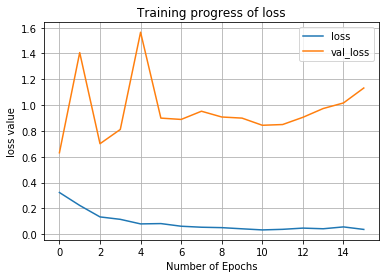

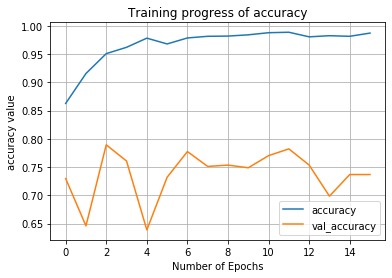

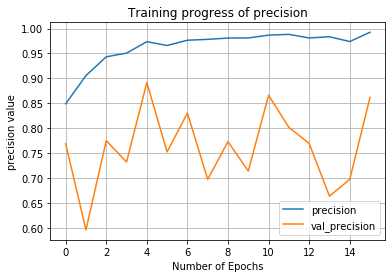

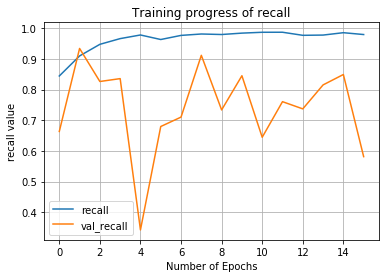

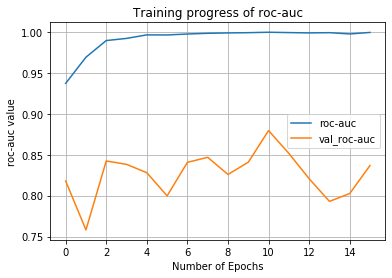

In [0]:
for name in ('loss','accuracy','precision','recall','roc-auc'):
    model.plot(name)

In [0]:
%%time
model.train( os.path.join('Data','Train'), os.path.join('Data','Valid'),
            batch_size=64, epochs=100, opt='Adam', lr=0.00001, verbose=1, unfreeze=10)

Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Epoch 1/100
25/25 [==============================] - 38s 2s/step - loss: 0.1854 - accuracy: 0.9236 - precision: 0.9134 - recall: 0.9174 - roc-auc: 0.9804 - val_loss: 0.6161 - val_accuracy: 0.7536 - val_precision: 0.8276 - val_recall: 0.6636 - val_roc-auc: 0.8238 - lr: 1.0000e-05
Epoch 2/100
25/25 [==============================] - 27s 1s/step - loss: 0.1592 - accuracy: 0.9443 - precision: 0.9276 - recall: 0.9496 - roc-auc: 0.9861 - val_loss: 0.4961 - val_accuracy: 0.7871 - val_precision: 0.7607 - val_recall: 0.8436 - val_roc-auc: 0.8766 - lr: 1.0000e-05
Epoch 3/100
25/25 [==============================] - 27s 1s/step - loss: 0.1207 - accuracy: 0.9543 - precision: 0.9580 - recall: 0.9383 - roc-auc: 0.9934 - val_loss: 0.5768 - val_accuracy: 0.7919 - val_precision: 0.8047 - val_recall: 0.7936 - val_roc-auc: 0.8539 - lr: 1.0000e-05
Epoch 4/100
25/25 [==============================] - 27s 1s/step - loss: 0.101

In [0]:
model.evaluate(os.path.join('Data','Valid'))

Found 118 images belonging to 2 classes.
118/118 [==============================] - 3s 26ms/step - loss: 0.6623 - accuracy: 0.7542 - precision: 0.7183 - recall: 0.8500 - roc-auc: 0.8614


{'loss': 0.6623170971870422,
 'accuracy': 0.7542372941970825,
 'precision': 0.7183098793029785,
 'recall': 0.8500000238418579,
 'roc-auc': 0.8613505959510803}

In [0]:
model.evaluate(os.path.join('Data','Test'))

Found 203 images belonging to 2 classes.
203/203 [==============================] - 5s 26ms/step - loss: 0.6595 - accuracy: 0.7537 - precision: 0.7069 - recall: 0.8367 - roc-auc: 0.8266


{'loss': 0.6595073342323303,
 'accuracy': 0.7536945939064026,
 'precision': 0.7068965435028076,
 'recall': 0.8367347121238708,
 'roc-auc': 0.826627790927887}

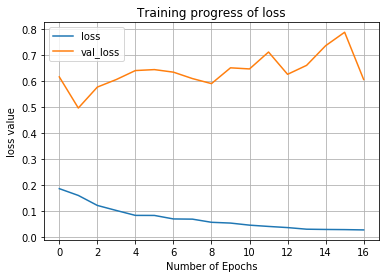

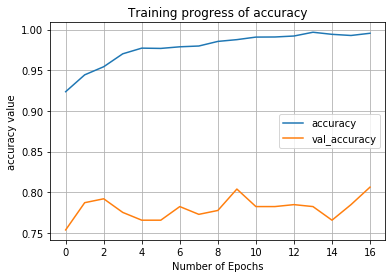

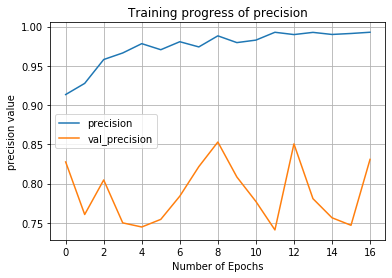

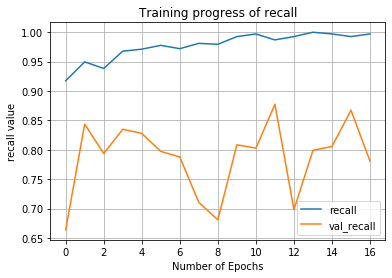

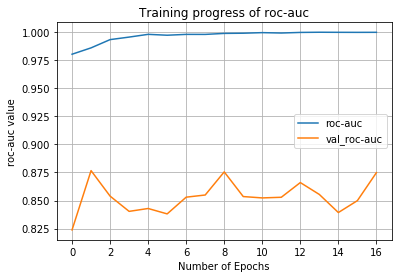

In [0]:
for name in ('loss','accuracy','precision','recall','roc-auc'):
    model.plot(name)

In [0]:
%%time
model.train( os.path.join('Data','Train'), os.path.join('Data','Valid'),
            batch_size=64, epochs=100, opt='Adam', lr=0.000003, verbose=1, unfreeze=15)

Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Epoch 1/100
25/25 [==============================] - 53s 2s/step - loss: 0.1347 - accuracy: 0.9517 - precision: 0.9429 - recall: 0.9485 - roc-auc: 0.9908 - val_loss: 0.6158 - val_accuracy: 0.7440 - val_precision: 0.7488 - val_recall: 0.7523 - val_roc-auc: 0.8283 - lr: 3.0000e-06
Epoch 2/100
25/25 [==============================] - 35s 1s/step - loss: 0.1047 - accuracy: 0.9688 - precision: 0.9706 - recall: 0.9608 - roc-auc: 0.9958 - val_loss: 0.6116 - val_accuracy: 0.7488 - val_precision: 0.7500 - val_recall: 0.7606 - val_roc-auc: 0.8346 - lr: 3.0000e-06
Epoch 3/100
25/25 [==============================] - 34s 1s/step - loss: 0.0957 - accuracy: 0.9726 - precision: 0.9710 - recall: 0.9682 - roc-auc: 0.9964 - val_loss: 0.5242 - val_accuracy: 0.7895 - val_precision: 0.7917 - val_recall: 0.7991 - val_roc-auc: 0.8662 - lr: 3.0000e-06
Epoch 4/100
25/25 [==============================] - 33s 1s/step - loss: 0.100

In [0]:
model.evaluate(os.path.join('Data','Valid'))

Found 118 images belonging to 2 classes.
118/118 [==============================] - 3s 26ms/step - loss: 0.5950 - accuracy: 0.7627 - precision: 0.7500 - recall: 0.8000 - roc-auc: 0.8701


{'loss': 0.5950431227684021,
 'accuracy': 0.7627118825912476,
 'precision': 0.75,
 'recall': 0.800000011920929,
 'roc-auc': 0.8701149225234985}

In [0]:
model.evaluate(os.path.join('Data','Test'))

Found 203 images belonging to 2 classes.
203/203 [==============================] - 5s 26ms/step - loss: 0.6302 - accuracy: 0.7488 - precision: 0.7423 - recall: 0.7347 - roc-auc: 0.8470


{'loss': 0.6302229166030884,
 'accuracy': 0.7487684488296509,
 'precision': 0.7422680258750916,
 'recall': 0.7346938848495483,
 'roc-auc': 0.8469873070716858}

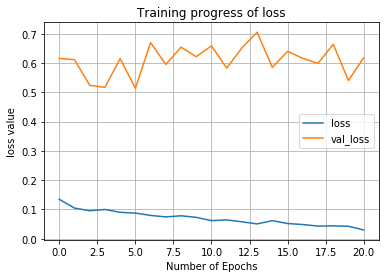

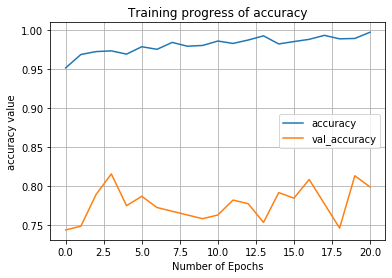

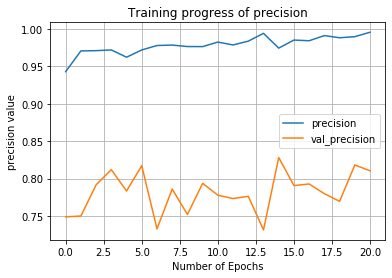

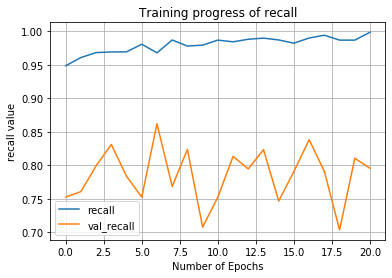

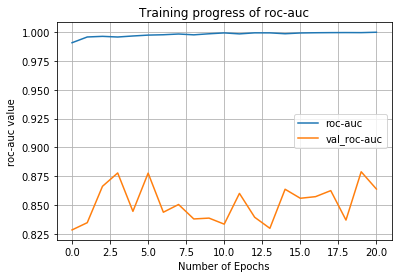

In [0]:
for name in ('loss','accuracy','precision','recall','roc-auc'):
    model.plot(name)